In [27]:
# Import necessary libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import math  # Add this import


In [28]:
def load_data(file_path):
    # Load the data (replace with actual data loading logic)
    data = pd.read_csv(file_path)  # Replace with your actual data file
    data.head()

    agg_data = data.groupby(['epoch', 't_bin'])["t_loss"].mean().reset_index()
    agg_data["loss_median"] = data.groupby(['epoch', 't_bin'])["t_loss"].quantile(0.5).values
    agg_data["loss_lower"] = data.groupby(['epoch', 't_bin'])["t_loss"].quantile(0.25).values
    agg_data["loss_upper"] = data.groupby(['epoch', 't_bin'])["t_loss"].quantile(0.75).values

    agg_data.head()

    return agg_data

In [29]:
def plot_all_losses():
    strats = ["uniform", "logit_normal", "sinusoidal", "quadratic", "adaptive"]
    data_frames = [load_data(strat + "_sample_log.csv") for strat in strats]

    fig, axes = plt.subplots(1, 5, figsize=(20, 4), sharey=True)

    for ax, strat, df in zip(axes, strats, data_frames):
        # Extract unique epochs
        epochs = df['epoch'].unique()

        for epoch in epochs:
            epoch_data = df[df['epoch'] == epoch]
            t_bins = epoch_data['t_bin']

            # Plot the line
            ax.plot(t_bins, epoch_data["loss_median"], label=f'Epoch {epoch}')
            
            # Add shaded area
            ax.fill_between(t_bins, epoch_data['loss_lower'], epoch_data['loss_upper'], alpha=0.2)

        ax.set_title(f'{strat.capitalize()} Strategy')
        ax.set_xlabel('t_bin')
        ax.set_ylabel('t_loss')
        ax.legend()
        ax.grid(True)

    plt.tight_layout()
    plt.show()

In [ ]:
import torch

def plot_all_distributions():
    # Number of samples and device
    b = 10000
    device = 'cpu'

    # Generate samples for each distribution
    distributions = {
        "Uniform": torch.rand((b,)).to(device).numpy(),
        "Logit-normal": torch.sigmoid(torch.randn((b,)).to(device)).numpy(),
        "Sinusoidal": (0.5 + 0.5 * torch.sin(torch.pi * (torch.rand((b,)).to(device) - 0.5))).numpy(),
        "Quadratic": (torch.rand((b,)).to(device) ** 2).numpy()
    }

    # Plot the distributions
    fig, axes = plt.subplots(1, 4, figsize=(16, 4), sharey=True)

    for ax, (name, dist) in zip(axes, distributions.items()):
        ax.hist(dist, bins=200, density=True, alpha=0.6, label=name)
        ax.set_title(name)
        ax.set_xlabel("t")
        ax.set_ylabel("Density")

    plt.tight_layout()
    plt.show()

In [34]:
import seaborn as sns

def plot_avg_beta_distributions_joint(file_path):
    # Load the data
    data = pd.read_csv(file_path)

    # Group by epoch and calculate the mean of alpha and beta over all t_bins
    avg_data = data.groupby('epoch')[['last_alpha', 'last_beta']].mean().reset_index()

    # Extract unique epochs
    epochs = avg_data['epoch'].unique()

    # Generate a reversed Blues color palette
    palette = sns.color_palette("Blues_r", len(epochs))

    # Plot the average beta distributions for each epoch in a single plot
    plt.figure(figsize=(8, 4))

    for i, epoch in enumerate(epochs):
        epoch_data = avg_data[avg_data['epoch'] == epoch]
        alpha = epoch_data['last_alpha'].values[0]
        beta = epoch_data['last_beta'].values[0]

        # Generate average beta distribution
        x = np.linspace(0, 1, 500)
        y = (x ** (alpha - 1)) * ((1 - x) ** (beta - 1)) / (math.gamma(alpha) * math.gamma(beta) / math.gamma(alpha + beta))
        
        # Use the color from the palette
        plt.plot(x, y, label=f'Epoch {epoch}: $t \\sim \\mathrm{{Beta}}(\\alpha={alpha:.2f}, \\beta={beta:.2f})$', 
                 color=palette[i])

    plt.title('Average Beta Distributions')
    plt.xlabel('t')
    plt.ylabel('Density')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


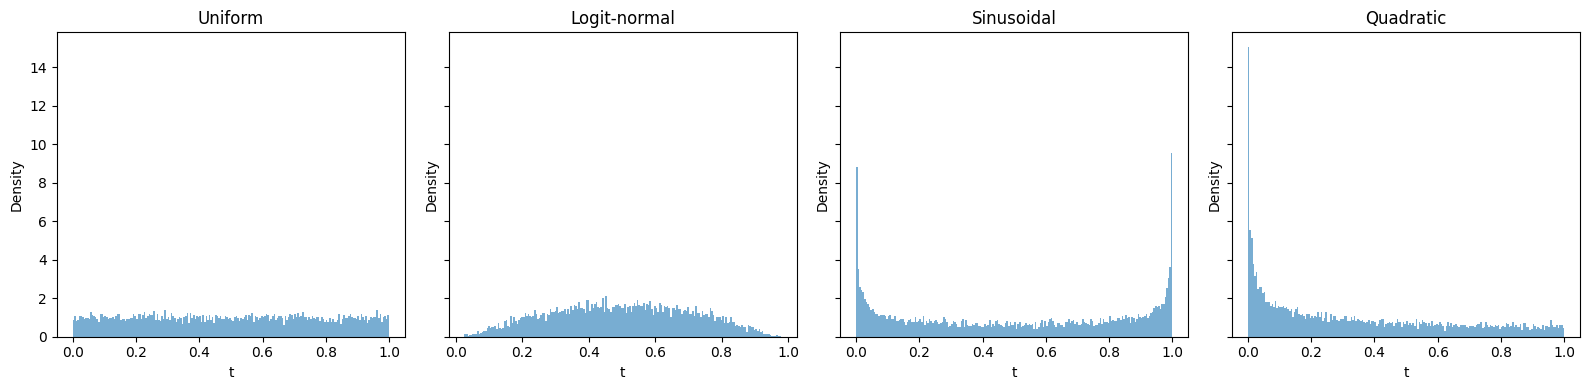

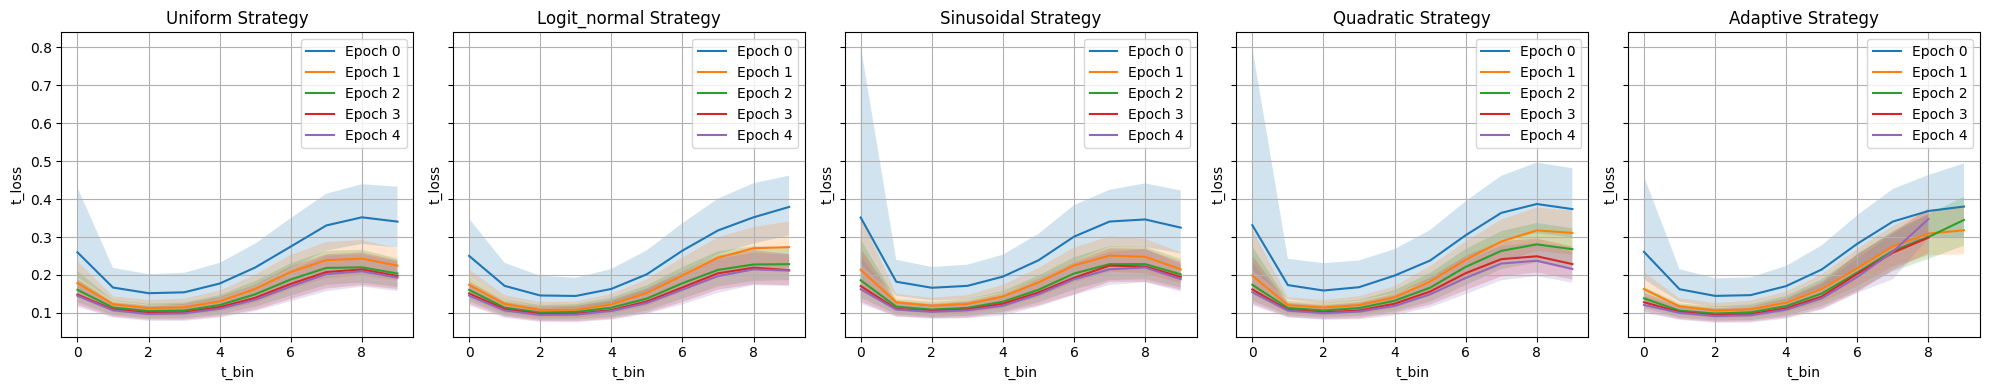

/var/folders/qy/nd4dhjwd1bzfv6sz65bz5xg80000gn/T/ipykernel_75226/1615341267.py:26: RuntimeWarning: divide by zero encountered in power
  y = (x ** (alpha - 1)) * ((1 - x) ** (beta - 1)) / (math.gamma(alpha) * math.gamma(beta) / math.gamma(alpha + beta))


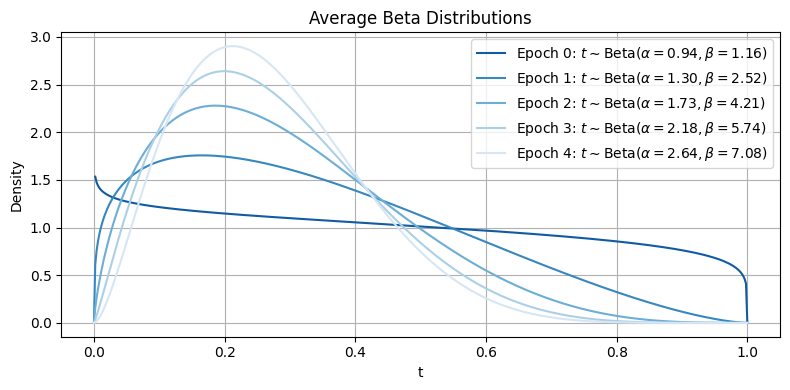

In [33]:
plot_all_distributions()
plot_all_losses()
plot_avg_beta_distributions_joint('adaptive_sample_log.csv')

In [49]:
import numpy as np
import matplotlib.pyplot as plt
import glob, os

def plot_figure2_np(np_dir, out="fig2_rf.png"):
    # find files grad_var_epoch_*.npy and loss_mean_epoch_*.npy
    gv_files = sorted(glob.glob(os.path.join(np_dir, "grad_var_epoch_*.npy")))
    lm_files = sorted(glob.glob(os.path.join(np_dir, "loss_mean_epoch_*.npy")))

    n = len(gv_files)
    if n == 0:
        print("No files found.")
        return

    # stack
    grads = [np.load(f) for f in gv_files]
    loss = [np.load(f) for f in lm_files]
    grads = np.stack(grads)  # (epochs, T)
    loss = np.stack(loss)
    
    # Add small constant to grads to prevent log scale issues

    print(grads)
    print(loss)

    T = grads.shape[1]
    t_idx = np.arange(T)
    cmap = plt.get_cmap("viridis")
    colors = [cmap(i / max(1, n-1)) for i in range(n)]

    fig, axes = plt.subplots(2, 1, figsize=(10, 6), sharex=True)
    for e in range(n):
        axes[0].plot(t_idx, grads[e], color=colors[e], alpha=0.9)
        axes[1].plot(t_idx, loss[e], color=colors[e], alpha=0.9)
    axes[0].set_yscale('log')
    axes[1].set_yscale('log')
    axes[0].set_ylabel("Gradient variance (proxy)")
    axes[1].set_ylabel("RF loss")
    axes[1].set_xlabel("timestep index")
    plt.tight_layout()
    plt.savefig(out, dpi=200)
    plt.show()


[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.

/var/folders/qy/nd4dhjwd1bzfv6sz65bz5xg80000gn/T/ipykernel_75226/851599634.py:35: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  axes[0].set_yscale('log')


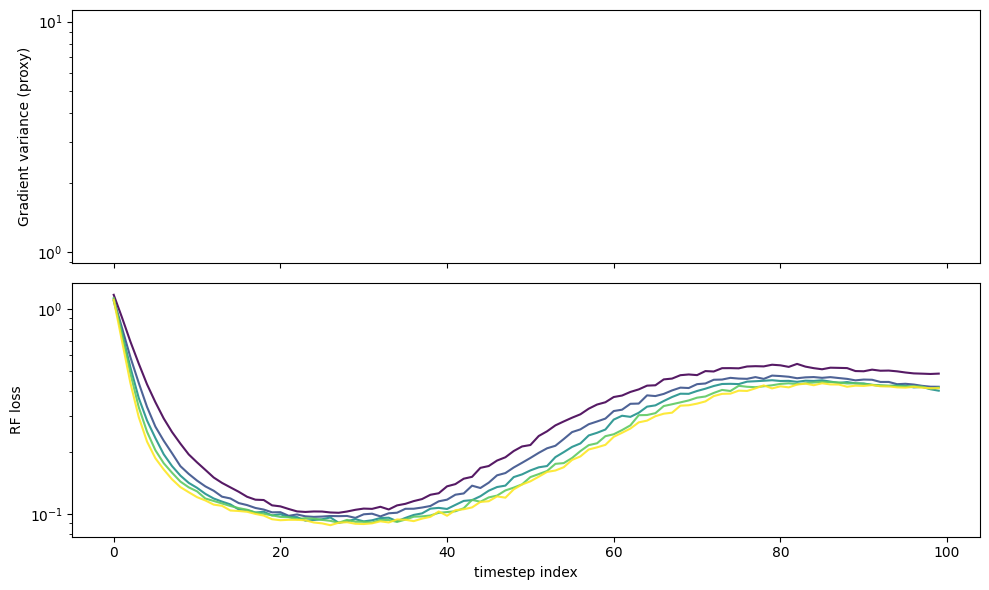

In [50]:
plot_figure2_np(np_dir="contents")